
# Protein Secondary Structure Prediction
Authors: Amina & Diyar
Date: 2026-02-10
Dataset: Protein Secondary Structure dataset (https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure)
Description: Predict protein secondary structure (Q3) from primary sequence



# 1. Environment Setup

In [10]:

!pip install biopython scikit-learn matplotlib seaborn numpy pandas tensorflow keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os


"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.



# 2. Data Acquisition & Preprocessing


In [11]:
# Load dataset 
df = pd.read_csv("dataset.csv")

# Check columns
print("Columns:", df.columns)
# Expected: ['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len', 'has_nonstd_aa']


Columns: Index(['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len', 'has_nonstd_aa'], dtype='object')


In [12]:
# Filter out sequences with nonstandard amino acids
df = df[df['has_nonstd_aa'] == False]

# Check dataset size
print("Dataset size after filtering:", len(df))


Dataset size after filtering: 386333


In [13]:
# Encode sequences for ML
# Build amino acid dictionary
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_to_int = {aa: i+1 for i, aa in enumerate(amino_acids)}  # 0 reserved for padding


In [14]:
# Limit maximum sequence length to 700 residues
MAX_LEN = 700

In [15]:
# Encode sequences
def encode_sequence(seq):
    # truncate if longer than MAX_LEN
    seq = seq[:MAX_LEN]
    return [aa_to_int.get(aa, 0) for aa in seq]

df['seq_encoded'] = df['seq'].apply(encode_sequence)


In [16]:
# Encode secondary structure (Q3)
def encode_ss(ss):
    ss = ss[:MAX_LEN]
    return [ss_mapping[c] for c in ss]


df['sst3_encoded'] = df['sst3'].apply(encode_ss)

In [17]:
# Pad sequences to MAX_LEN
X = pad_sequences(df['seq_encoded'], maxlen=MAX_LEN, padding='post', value=0)
y = pad_sequences(df['sst3_encoded'], maxlen=MAX_LEN, padding='post', value=2)

In [18]:
# y will be used directly in model with sparse_categorical_crossentropy
# This avoids creating huge one-hot arrays in memory
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (309066, 700)
y_train shape: (309066, 700)


# 3. Computational Methods & Implementation

In [20]:
# METHOD 1: Simple Feedforward Neural Network
print("\nTraining Feedforward Neural Network...")

input_dim = len(amino_acids) + 1  # embedding input size

model_ff = Sequential()
model_ff.add(Embedding(input_dim=input_dim, output_dim=20, input_length=MAX_LEN))
model_ff.add(Dense(64, activation='relu'))
model_ff.add(Dense(3, activation='softmax'))  # 3 classes for Q3

model_ff.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
history_ff = model_ff.fit(X_train, y_train, 
                           epochs=5, 
                           batch_size=64, 
                           validation_split=0.1)



Training Feedforward Neural Network...
Epoch 1/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8135 - loss: 0.3667 - val_accuracy: 0.8139 - val_loss: 0.3651
Epoch 2/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - accuracy: 0.8135 - loss: 0.3659 - val_accuracy: 0.8139 - val_loss: 0.3652
Epoch 3/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8135 - loss: 0.3659 - val_accuracy: 0.8139 - val_loss: 0.3651
Epoch 4/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - accuracy: 0.8135 - loss: 0.3659 - val_accuracy: 0.8139 - val_loss: 0.3651
Epoch 5/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.8135 - loss: 0.3659 - val_accuracy: 0.8139 - val_loss: 0.3651


In [22]:

# METHOD 2: LSTM
print("\nTraining LSTM model...")

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=input_dim, output_dim=20, input_length=max_len))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)



Training LSTM model...
Epoch 1/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 2045s 469ms/step - accuracy: 0.8855 - loss: 0.2623 - val_accuracy: 0.8947 - val_loss: 0.2446
Epoch 2/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 1790s 412ms/step - accuracy: 0.8982 - loss: 0.2377 - val_accuracy: 0.9011 - val_loss: 0.2317
Epoch 3/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 1838s 423ms/step - accuracy: 0.9027 - loss: 0.2289 - val_accuracy: 0.9045 - val_loss: 0.2252
Epoch 4/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 1809s 416ms/step - accuracy: 0.9051 - loss: 0.2240 - val_accuracy: 0.9057 - val_loss: 0.2228
Epoch 5/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 1830s 421ms/step - accuracy: 0.9068 - loss: 0.2205 - val_accuracy: 0.9066 - val_loss: 0.2208


In [26]:
from tensorflow.keras.layers import Conv1D, Embedding, Dense
from tensorflow.keras.models import Sequential

print("Training CNN model...")

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=input_dim, output_dim=32, input_length=MAX_LEN))

# convolution keeps sequence length
model_cnn.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model_cnn.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# output per residue
model_cnn.add(Dense(3, activation='softmax'))

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)


Training CNN model...
Epoch 1/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 133s 30ms/step - accuracy: 0.8687 - loss: 0.2942 - val_accuracy: 0.8723 - val_loss: 0.2875
Epoch 2/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 128s 29ms/step - accuracy: 0.8728 - loss: 0.2869 - val_accuracy: 0.8740 - val_loss: 0.2848
Epoch 3/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 127s 29ms/step - accuracy: 0.8740 - loss: 0.2849 - val_accuracy: 0.8747 - val_loss: 0.2836
Epoch 4/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 128s 29ms/step - accuracy: 0.8746 - loss: 0.2839 - val_accuracy: 0.8753 - val_loss: 0.2826
Epoch 5/5
4347/4347 ━━━━━━━━━━━━━━━━━━━━ 127s 29ms/step - accuracy: 0.8751 - loss: 0.2831 - val_accuracy: 0.8754 - val_loss: 0.2825


# 4. Results & Analysis

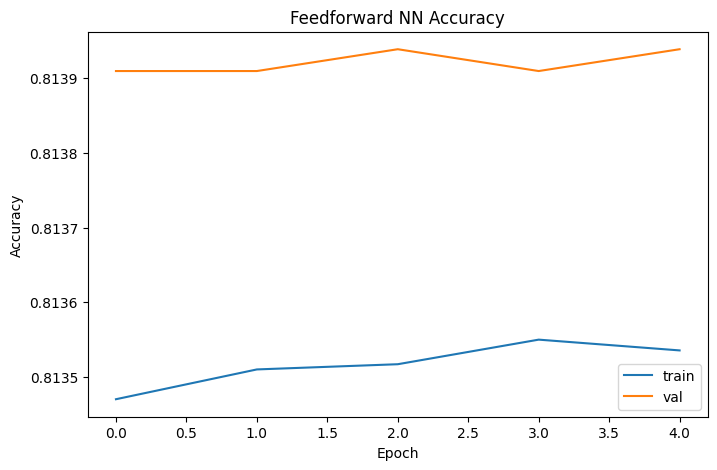

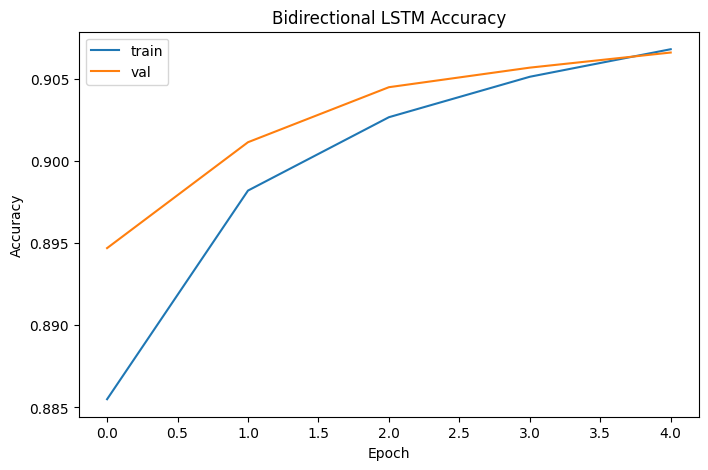

In [27]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_ff, "Feedforward NN Accuracy")
plot_history(history_lstm, "Bidirectional LSTM Accuracy")

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test):
    
    # predict
    y_pred = model.predict(X_test, batch_size=64)
    
    # predicted class per residue
    y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
    
    # TRUE labels already integers → just flatten
    y_true_labels = y_test.flatten()
    
    # remove padding (where X was 0)
    mask = (X_test.flatten() != 0)
    y_true_labels = y_true_labels[mask]
    y_pred_labels = y_pred_labels[mask]
    
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=['H','E','C']))
    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['H','E','C'],
                yticklabels=['H','E','C'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Feedforward model:
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           H       0.43      0.51      0.47   6717740
           E       0.40      0.13      0.20   4156681
           C       0.54      0.64      0.59   8785716

    accuracy                           0.49  19660137
   macro avg       0.46      0.43      0.42  19660137
weighted avg       0.47      0.49      0.46  19660137



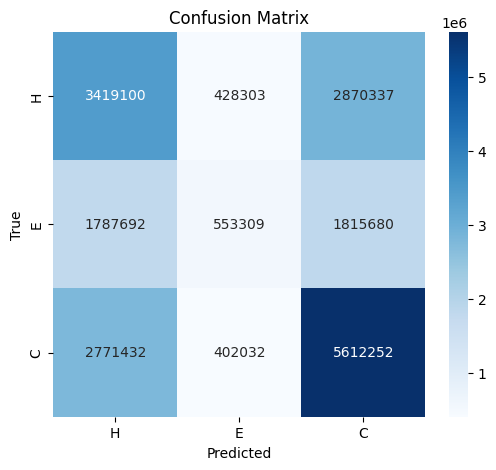

LSTM model:
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 213s 175ms/step

Classification Report:
              precision    recall  f1-score   support

           H       0.74      0.82      0.78   6717740
           E       0.73      0.62      0.67   4156681
           C       0.75      0.74      0.75   8785716

    accuracy                           0.74  19660137
   macro avg       0.74      0.73      0.73  19660137
weighted avg       0.74      0.74      0.74  19660137



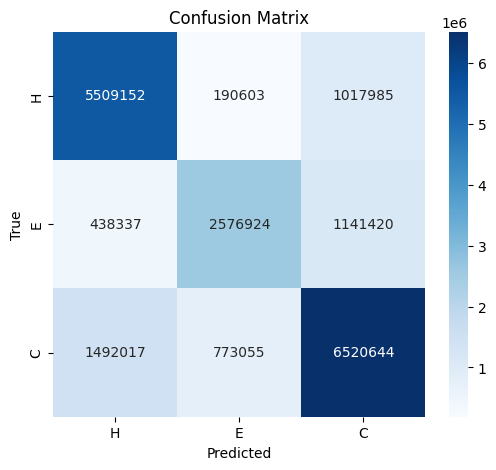

CNN model:
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           H       0.63      0.69      0.66   6717740
           E       0.61      0.44      0.51   4156681
           C       0.69      0.73      0.71   8785716

    accuracy                           0.66  19660137
   macro avg       0.64      0.62      0.63  19660137
weighted avg       0.65      0.66      0.65  19660137



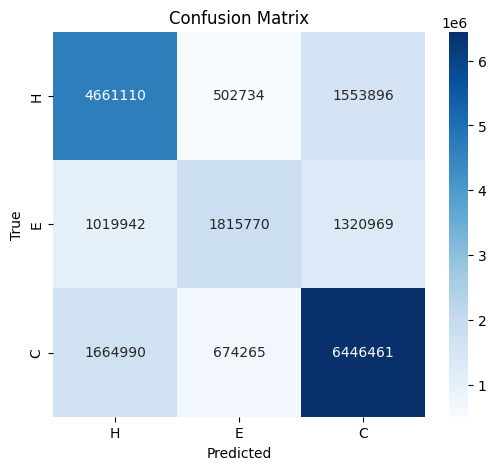

In [30]:
print("Feedforward model:")
evaluate_model(model_ff, X_test, y_test)

print("LSTM model:")
evaluate_model(model_lstm, X_test, y_test)

print("CNN model:")
evaluate_model(model_cnn, X_test, y_test)
